## %%configure -f

{"executorMemory": "1G","driverMemory":"1G","executorCores": 1,"numExecutors": 5,

 "conf": {"spark.dynamicAllocation.enabled": "false",

          "spark.sql.parquet.enableVectorizedReader": "false",

          "spark.python.use.daemon": "false",

          "spark.pyspark.python": "python3",

          "spark.pyspark.virtualenv.enabled": "true",

          "spark.pyspark.virtualenv.type": "native",

          "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"}}

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
108,application_1719191243691_0109,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("seaborn")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("pandas")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#import data
df = spark.read.options(inferSchema=True).csv('/users/patrick_xiao/charts.csv', header=True)
df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 253019|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP| 223988|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN| 210943|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION| 173865|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP| 153956|
|         Traicionera|   6|2017-01-01|  

When reading from the CSV file, the inferred data type(s) may not be accurate. To ensure consistency and accuracy for the purpose of my analysis, I will transform the dataframe using the following format: 
- The "rank" column is cast to a long integer (LongType).
- The "date" column is cast to a date (DateType).
- The "streams" column is cast to an integer (IntegerType).

In [6]:
df = df.withColumn("rank", f.col("rank").cast(t.LongType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[title: string, rank: bigint, date: date, artist: string, url: string, region: string, chart: string, trend: string, streams: int]

In [8]:
# Register temp table
df.createOrReplaceTempView("charts")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exploratory Data Analysis: Spotify Charts

1. Number of regions in the data

In [9]:
spark.sql("""
SELECT COUNT(DISTINCT region) AS Region_Count
FROM charts
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|Region_Count|
+------------+
|         208|
+------------+

2. Timeline of the data 

In [10]:
spark.sql("""
SELECT MIN(date) begin, MAX(date) end 
FROM charts 
WHERE chart = 'top200'
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+
|     begin|       end|
+----------+----------+
|2017-01-01|2021-12-31|
+----------+----------+

3. What are the top 10 songs that appeared in the top 200 chart between 2017 and 2021?

In [11]:
spark.sql("""
SELECT * 
FROM charts
WHERE chart = 'top200'
LIMIT 10
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 253019|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP| 223988|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN| 210943|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION| 173865|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP| 153956|
|         Traicionera|   6|2017-01-01|  

4. What are the regions with the highest number of unique song titles on the top 200 chart? 


In [12]:
spark.sql("""
SELECT region, COUNT(DISTINCT title) AS title_count
FROM charts
WHERE chart = 'top200'
GROUP BY region
ORDER BY title_count DESC
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----------+
|        region|title_count|
+--------------+-----------+
|   Switzerland|       8597|
|       Germany|       7888|
|       Finland|       7750|
|        Taiwan|       7695|
|        Sweden|       7687|
| United States|       7541|
|        France|       7211|
|       Austria|       7141|
|   Netherlands|       7086|
|        Norway|       6972|
|United Kingdom|       6955|
|       Belgium|       6507|
|        Canada|       6315|
|        Global|       6155|
|         Italy|       5974|
|       Denmark|       5868|
|Czech Republic|       5687|
|       Ireland|       5658|
|        Poland|       5558|
|       Hungary|       5538|
+--------------+-----------+
only showing top 20 rows

5. Most streamed song in each of the 6 most unique regions

In [13]:
spark.sql("""
SELECT region, title, artist, total_streams
FROM (
    SELECT region, title, artist, SUM(streams) AS total_streams,
           ROW_NUMBER() OVER (PARTITION BY region ORDER BY SUM(streams) DESC) AS rank
    FROM charts
    WHERE chart = 'top200' AND region IN ('Switzerland', 'Germany', 'Finland', 'Taiwan', 'Sweden', 'United States')
    GROUP BY region, title, artist
) ranked
WHERE rank = 1
ORDER BY region
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------------+--------------------+-------------+
|       region|               title|              artist|total_streams|
+-------------+--------------------+--------------------+-------------+
|      Finland|       Ikuinen vappu|                 JVG|     25425359|
|      Germany|              Roller|          Apache 207|    242023609|
|       Sweden|                Svag|      Victor Leksell|     93720518|
|  Switzerland|        Dance Monkey|         Tones And I|     22023157|
|       Taiwan|         Without You|          高爾宣 OSN|     26531472|
|United States|Sunflower - Spide...|Post Malone, Swae...|    778581058|
+-------------+--------------------+--------------------+-------------+

6. Plotting total streams of the top 20 songs in the top 200 chart 

In [14]:
top20_plot = spark.sql("""
SELECT title, artist, SUM(streams) AS total_streams
FROM charts
WHERE chart = 'top200'
GROUP BY title, artist
ORDER BY total_streams DESC
LIMIT 20
""").toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

plt.figure(figsize=(14, 8))

sns.barplot(x='total_streams', y='title', hue='title', data=top20_plot, dodge=False, palette='viridis')

plt.title('Total Streams of the Top 20 Songs in the Top 200 Chart')
plt.xlabel('Total Streams (in billions)')
plt.ylabel('Song')

plt.yticks(rotation=0)


plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

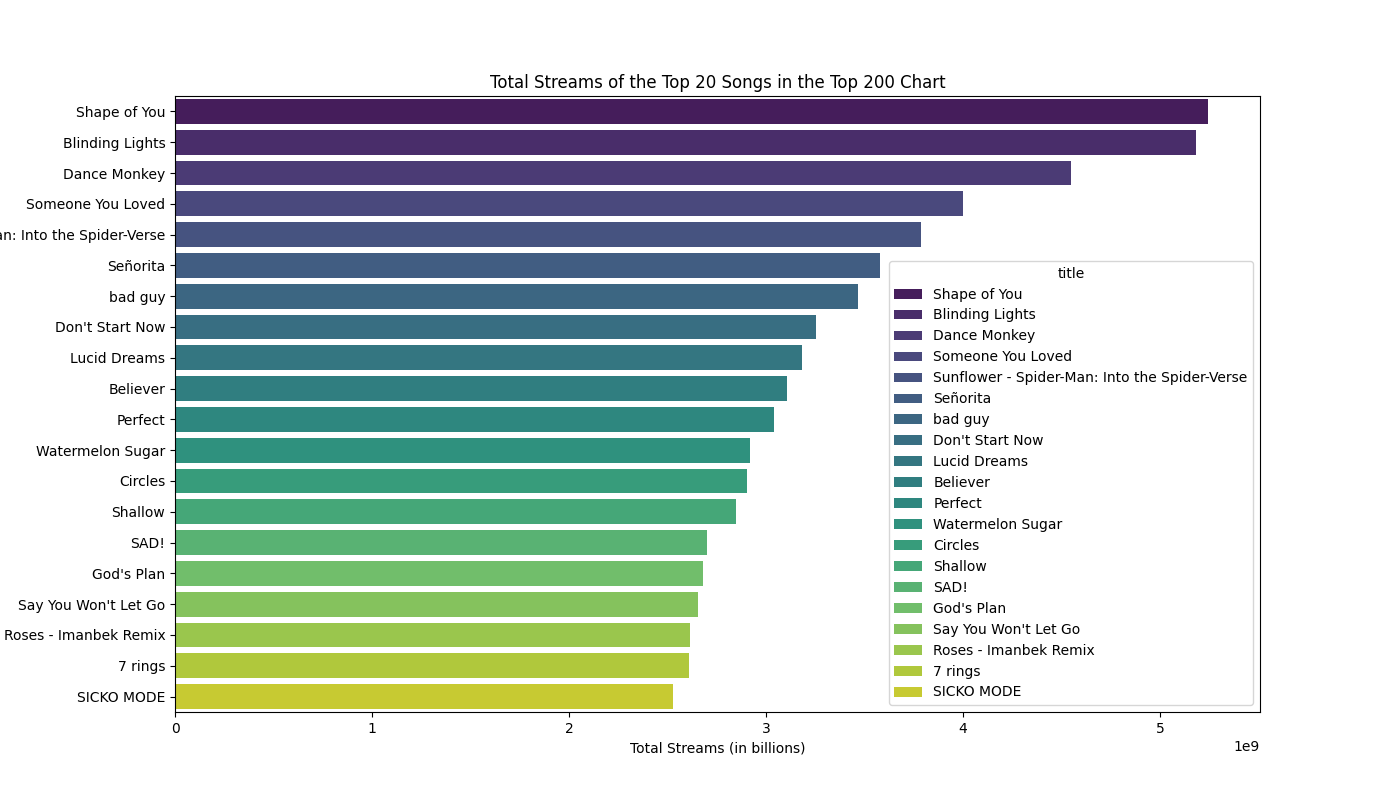

In [16]:
%matplot plt

Exploratory Data Analysis: Ed Sheeran

1. Total number of songs by Ed Sheeran that has appeared in the top 200

In [17]:
spark.sql("""  
SELECT COUNT(DISTINCT title) AS NoOfSongs 
FROM charts
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200'
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|NoOfSongs|
+---------+
|      121|
+---------+

2. Total number of times Ed Sheeran appeared in the top 200

In [18]:
spark.sql("""
SELECT COUNT(*) AS TimesInTop200 
FROM charts
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200'
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|TimesInTop200|
+-------------+
|       368388|
+-------------+

In [19]:
# number of times Ed Sheeran appeared in top 200 by listing all the artists 
spark.sql("""
SELECT artist, COUNT(artist) AS count
FROM charts
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200'
GROUP BY artist
ORDER BY count DESC
LIMIT 10
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|              artist| count|
+--------------------+------+
|          Ed Sheeran|366026|
|Taylor Swift, Ed ...|  1995|
|Tori Kelly, Ed Sh...|   176|
|Ed Sheeran, Elton...|   125|
|Fireboy DML, Ed S...|    19|
|Alonestar, Rick L...|    14|
|The Weeknd, Ed Sh...|     9|
|Taylor Swift, Ed ...|     8|
|Alonestar, Herber...|     8|
|Foy Vance, Ed She...|     4|
+--------------------+------+

3. Ed Sheeran's top 10 songs 

In [20]:
spark.sql("""
SELECT title, SUM(streams) streams
FROM charts
WHERE artist LIKE '%Ed Sheeran%' 
AND streams IS NOT NULL
GROUP BY title
ORDER BY streams DESC
LIMIT 10
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+
|               title|   streams|
+--------------------+----------+
|        Shape of You|5245740051|
|             Perfect|3038712776|
|I Don't Care (wit...|2296138118|
|Beautiful People ...|1612020133|
|          Bad Habits|1473943611|
|          Photograph|1081454379|
|  Castle on the Hill|1021200333|
|         Galway Girl|1007337746|
|   Thinking out Loud| 853200137|
|             Happier| 782141998|
+--------------------+----------+

4. Number of days each song was on the top 200 chart

In [21]:
spark.sql("""
SELECT title, count(*) AS days
FROM charts
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200'
GROUP BY title
ORDER BY days DESC
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|               title| days|
+--------------------+-----+
|        Shape of You|65262|
|             Perfect|52392|
|          Photograph|28605|
|I Don't Care (wit...|27101|
|   Thinking out Loud|26014|
|Beautiful People ...|21799|
|             Happier|17056|
|         Galway Girl|15614|
|  Castle on the Hill|14653|
|Perfect Duet (Ed ...|11258|
|          Bad Habits|10449|
|South of the Bord...| 9544|
|                Dive| 5881|
|           Afterglow| 5267|
|             Shivers| 4706|
|Cross Me (feat. C...| 4411|
| Supermarket Flowers| 3512|
|How Would You Fee...| 3249|
|     What Do I Know?| 3210|
|             New Man| 2591|
+--------------------+-----+
only showing top 20 rows

5. What are the highest ranks each song has hit and the frequency of hitting that milestone?

In [22]:
spark.sql("""
SELECT title, MIN(rank) As rank, COUNT(rank) AS count
FROM charts
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200'
AND rank <=5
GROUP BY title
ORDER BY count DESC 
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+-----+
|               title|rank|count|
+--------------------+----+-----+
|        Shape of You|   1| 8565|
|          Bad Habits|   1| 2601|
|I Don't Care (wit...|   1| 2537|
|Beautiful People ...|   1| 1623|
|  Castle on the Hill|   1| 1285|
|             Shivers|   1|  879|
|             Perfect|   1|  795|
|         Galway Girl|   1|  707|
|Perfect Duet (Ed ...|   1|  245|
|Antisocial (with ...|   2|   85|
|           Afterglow|   2|   32|
|Cross Me (feat. C...|   4|   28|
|             New Man|   3|   28|
|South of the Bord...|   3|   22|
|Take Me Back to L...|   2|   13|
|      Nancy Mulligan|   3|   11|
|             Happier|   3|   11|
|                Dive|   4|    9|
|   Overpass Graffiti|   3|    4|
|              Eraser|   2|    4|
+--------------------+----+-----+
only showing top 20 rows

6. Plotting the trends of "Photograph", "Shivers", and "Shape of You" in the Top 200 chart over time


In [23]:
Trends_Top200 = spark.sql('''
SELECT title,YEAR(date) AS year, date, rank, region 
FROM charts 
WHERE title IN ('Photograph', 'Shivers', 'Shape of You') 
AND chart='top200'
ORDER BY rank ASC
''').toPandas()

Trends_Top200.head(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           title  year        date  rank       region
0   Shape of You  2017  2017-05-23     1        Japan
1   Shape of You  2017  2017-03-28     1    Indonesia
2   Shape of You  2017  2017-03-28     1        Japan
3   Shape of You  2017  2017-03-28     1       Latvia
4   Shape of You  2017  2017-05-23     1       Turkey
5   Shape of You  2017  2017-05-24     1   Costa Rica
6   Shape of You  2017  2017-05-24     1        Japan
7   Shape of You  2017  2017-06-24     1        Japan
8   Shape of You  2017  2017-03-28     1    Lithuania
9   Shape of You  2017  2017-03-28     1   Luxembourg
10  Shape of You  2017  2017-03-28     1     Malaysia
11  Shape of You  2017  2017-03-28     1  New Zealand
12  Shape of You  2017  2017-03-28     1  Philippines
13  Shape of You  2017  2017-03-28     1       Poland
14  Shape of You  2017  2017-07-10     1        Japan
15  Shape of You  2017  2017-05-24     1       Turkey
16  Shape of You  2017  2017-03-28     1    Singapore
17  Shape of You  2017  2017

In [24]:
from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(figsize=(20, 7))
sns.lineplot(x='date', y='rank', data=Trends_Top200, hue='title', errorbar=None).set_title('Trends in Top 200 of Photograph, Shivers, and Shape of You')

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  

plt.legend(title='Song Title', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

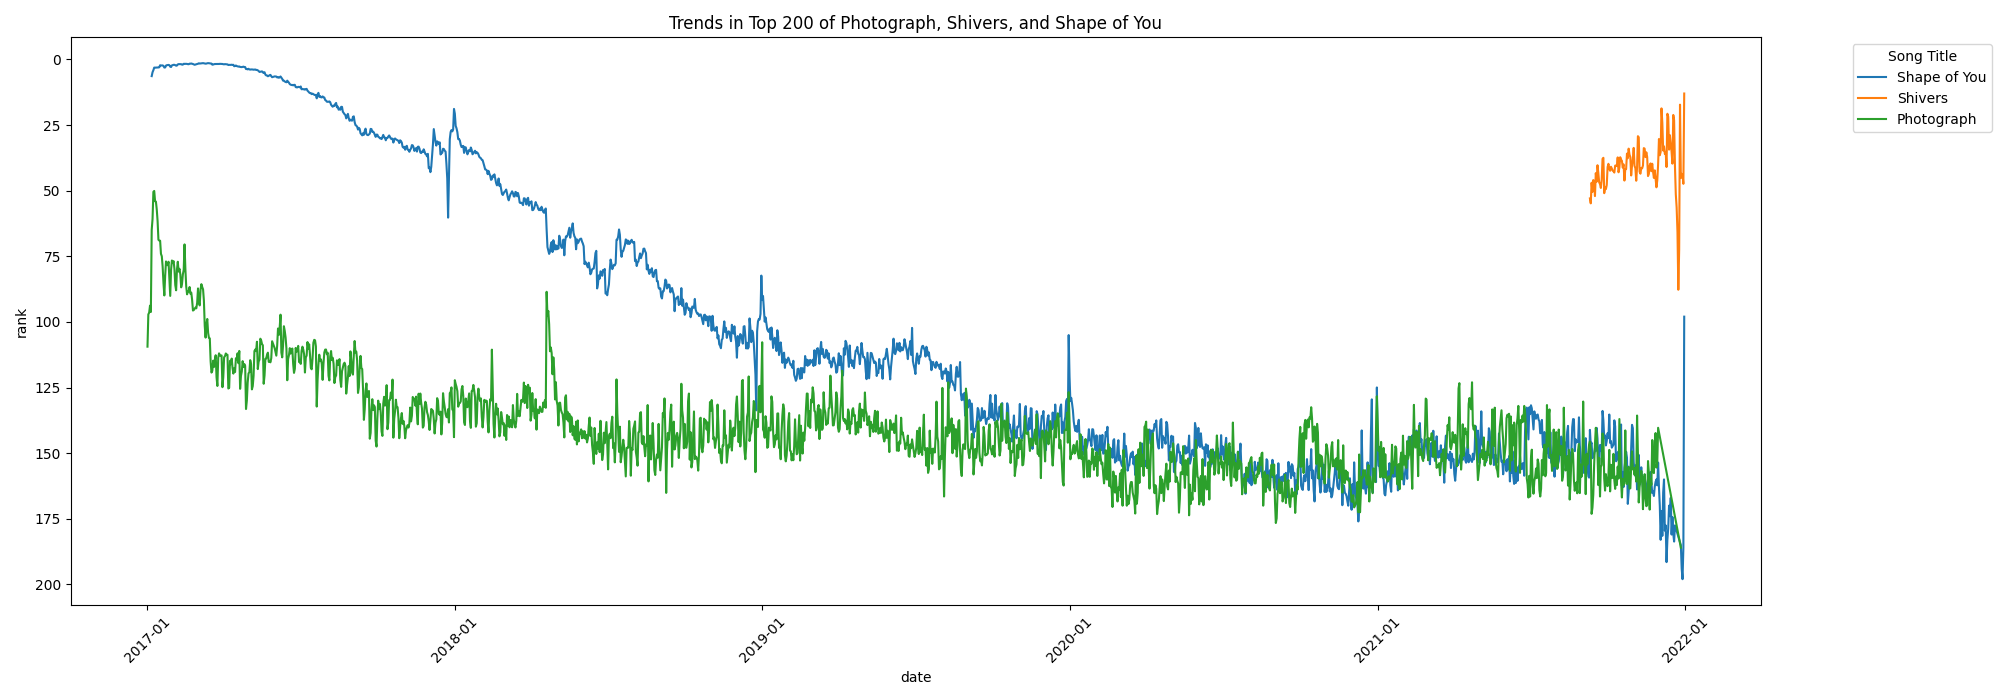

In [25]:
%matplot plt

Conclusions: "Photograph", "Shivers", and "Shape of You" in the Top 200 chart

- Shape of You has been trending in the Top 200 chart from the beginning of 2017 until the start of 2022 (dataset timeline cutoff) with a resurging rise of ~120 ranks in early 2022. 
- Photograph has been trending for a similar duration as Shape of You. Despite starting at a lower rank, it eventually evens out with Shape of You around early-mid 2020. 
- Shivers has been trending for a much shorter duration compared to Shape of You and Photograph, but already peaked at a higher rank than Photograph.  

7. Plotting the trends of "Photograph", "Shivers", and "Shape of You" in the Viral 50 chart over time

In [26]:
Trends_Viral50 = spark.sql("""
SELECT title, date, rank, region
FROM charts
WHERE title IN ('Photograph', 'Shivers', 'Shape of You')
AND chart='viral50'
""").toPandas()

Trends_Viral50.head(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           title        date  rank    region
0   Shape of You  2017-08-23    32  Thailand
1     Photograph  2019-11-03    32   Andorra
2     Photograph  2019-11-04    37   Andorra
3     Photograph  2019-11-05    41   Andorra
4     Photograph  2019-11-06    23   Andorra
5     Photograph  2019-11-07    20   Andorra
6     Photograph  2019-11-08    23   Andorra
7     Photograph  2019-11-09    28   Andorra
8     Photograph  2017-11-27    39     Japan
9     Photograph  2017-11-28    36     Japan
10    Photograph  2017-12-01    37     Japan
11       Shivers  2017-12-02    50   Estonia
12    Photograph  2017-12-02    40     Japan
13       Shivers  2017-12-06    49   Estonia
14    Photograph  2017-12-07     5   Andorra
15       Shivers  2017-12-07    49   Estonia
16    Photograph  2017-11-29    32     Japan
17    Photograph  2017-12-08     5   Andorra
18       Shivers  2017-12-08    44   Estonia
19    Photograph  2017-11-30    29     Japan

In [27]:
fix, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x='date', y='rank', data=Trends_Viral50, hue='title', errorbar=None).set_title('Trends in Viral 50 of Photograph, Shivers, and Shape of You')

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.gca().invert_yaxis()

plt.legend(title='Song Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()                                                   

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Conclusions: "Photograph", "Shivers", and "Shape of You" in the Viral 50 chart

- Both "Photograph" and "Shape of you" have been trending for a similar duration in the Viral 50 chart, fading in popularity around mid 2021.
- "Shivers" started to trend in the Viral 50 chart late 2017 with a steady increase until late 2021, where it peaked at rank ~18 before dropping down to rank 50 in 2022.

Difference between the Viral 50 and Top 200 charts: 
- Unlike the Top 200 chart where it suggests "Shivers" has been trending for a much shorter period of time but is ranked higher than both "Shape of You" and "Photograph" around early 2022, the Viral 50 chart suggests "Shivers" started trending a while later but for roughly the same total time as the other songs. 

7. What are average ranks of the songs?

In [28]:
spark.sql("""
SELECT title, MIN(rank) AS Highest, MAX(rank) AS lowest, AVG(rank) AS Avg 
FROM charts
WHERE title IN ('Photograph', 'Shape of You', 'Shivers')
AND chart='top200'
GROUP BY title
ORDER BY Highest
""").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-------+------+------------------+
|       title|Highest|lowest|               Avg|
+------------+-------+------+------------------+
|Shape of You|      1|   200| 80.52784162299653|
|     Shivers|      1|   200| 41.89949001274968|
|  Photograph|      2|   200|128.14158556436809|
+------------+-------+------+------------------+

8. How are streams distributed across different regions for "Photograph"?

In [29]:
Photograph_AvgStreams = spark.sql("""
SELECT region, AVG(streams) AS Avg_Streams
FROM charts
WHERE title = 'Photograph' 
AND chart='top200'
GROUP BY region
ORDER BY Avg_Streams DESC
""").toPandas()

Photograph_AvgStreams.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           region    Avg_Streams
0          Global  686243.051818
1   United States  351961.790000
2          Brazil   60168.655125
3  United Kingdom   56740.837054
4          Mexico   49977.435146

To demonstrate Horizontal Scaling and the benefits of distributed computing, we will measure the execution time for query number 8 and repeat that for a new configuration of 12 executors. In theory with 12 executors, more tasks can be executed in parallel which should reduce the execution time. 

In [30]:
import time
start_time = time.time()

Photograph_AvgStreams = spark.sql("""
SELECT region, AVG(streams) AS Avg_Streams
FROM charts
WHERE title = 'Photograph' 
AND chart='top200'
GROUP BY region
ORDER BY Avg_Streams DESC
""").toPandas()

Photograph_AvgStreams.head()

print("--- %s seconds ---" % (time.time() - start_time))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 15.823218584060669 seconds ---

In [31]:
%%configure -f
{"executorMemory": "1.5G","driverMemory":"1G","executorCores": 1,"numExecutors": 12,

 "conf": {"spark.dynamicAllocation.enabled": "false",

          "spark.sql.parquet.enableVectorizedReader": "false",

          "spark.python.use.daemon": "false",

          "spark.pyspark.python": "python3",

          "spark.pyspark.virtualenv.enabled": "true",

          "spark.pyspark.virtualenv.type": "native",

          "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"}}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
109,application_1719191243691_0110,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
42,application_1719191243691_0043,pyspark,idle,Link,Link,None,
70,application_1719191243691_0071,pyspark,idle,Link,Link,None,
106,application_1719191243691_0107,pyspark,idle,Link,Link,None,
109,application_1719191243691_0110,pyspark,idle,Link,Link,None,✔


In [32]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
sc.install_pypi_package("seaborn")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("pandas")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
df = spark.read.options(inferSchema=True).csv('/users/patrick_xiao/charts.csv', header=True)
df.repartition(30)
df = df.withColumn("rank", f.col("rank").cast(t.LongType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))
df.createOrReplaceTempView("charts")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
import time
start_time = time.time()

Photograph_AvgStreams = spark.sql("""
SELECT region, AVG(streams) AS Avg_Streams
FROM charts
WHERE title = 'Photograph' 
AND chart='top200'
GROUP BY region
ORDER BY Avg_Streams DESC
""").toPandas()

Photograph_AvgStreams.head()


print("--- %s seconds ---" % (time.time() - start_time))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 11.957165479660034 seconds ---

In [36]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

plt.figure(figsize=(14, 8))

Photograph_AvgStreams = Photograph_AvgStreams.sort_values(by='Avg_Streams', ascending=False)

plt.figure(figsize=(16, 10))

sns.barplot(x='Avg_Streams', y='region', data=Photograph_AvgStreams, palette='viridis')

plt.title('Average Streams of "Photograph" by Region', fontsize=16)
plt.xlabel('Average Streams', fontsize=14)
plt.ylabel('Region', fontsize=14)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

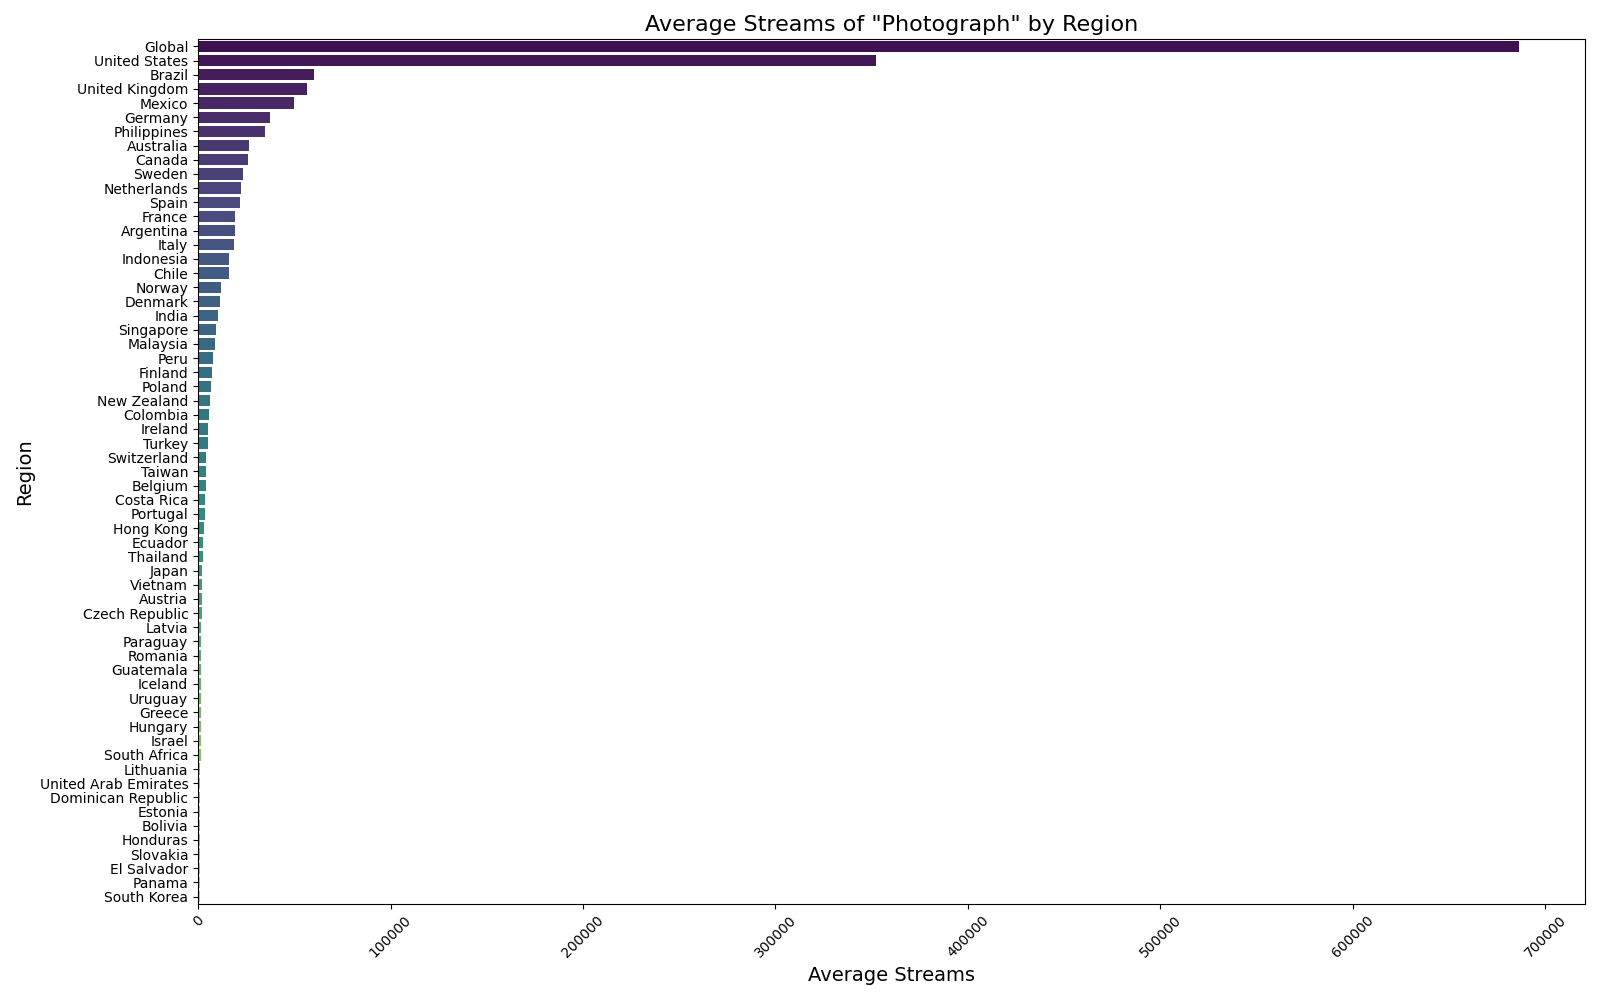

In [37]:
%matplot plt